In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime, timedelta
from scipy import stats
from scipy.signal import find_peaks

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Figure size
plt.rcParams['figure.figsize'] = (14, 6)

## Setup and Data Loading

/var/folders/31/8pp98wv16bndwy82vg6vrpv00000gp/T/ipykernel_90770/1972840313.py:25: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[1].boxplot(data_by_year, labels=years, patch_artist=True)


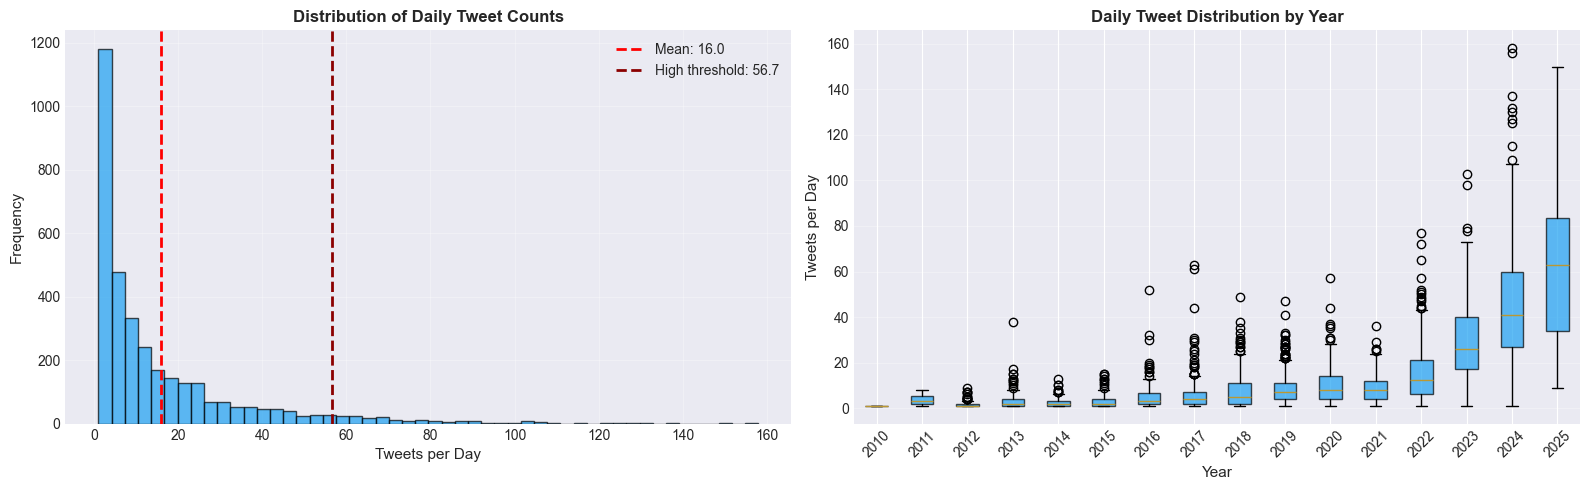

In [10]:
# Distribution of tweet counts
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Histogram
axes[0].hist(daily_tweets['tweet_count'], bins=50, 
             color='#1DA1F2', alpha=0.7, edgecolor='black')
axes[0].axvline(mean_tweets, color='red', linestyle='--', 
                linewidth=2, label=f'Mean: {mean_tweets:.1f}')
axes[0].axvline(threshold_high, color='darkred', linestyle='--', 
                linewidth=2, label=f'High threshold: {threshold_high:.1f}')
axes[0].set_xlabel('Tweets per Day', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].set_title('Distribution of Daily Tweet Counts', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Box plot by year
df_tweets['year'] = df_tweets['createdAt'].dt.year
yearly_tweet_dist = df_tweets.groupby(['year', df_tweets['createdAt'].dt.date]).size().reset_index(name='count')
yearly_tweet_dist.columns = ['year', 'date', 'count']

years = sorted(yearly_tweet_dist['year'].unique())
data_by_year = [yearly_tweet_dist[yearly_tweet_dist['year'] == year]['count'].values for year in years]

bp = axes[1].boxplot(data_by_year, labels=years, patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('#1DA1F2')
    patch.set_alpha(0.7)

axes[1].set_xlabel('Year', fontsize=11)
axes[1].set_ylabel('Tweets per Day', fontsize=11)
axes[1].set_title('Daily Tweet Distribution by Year', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

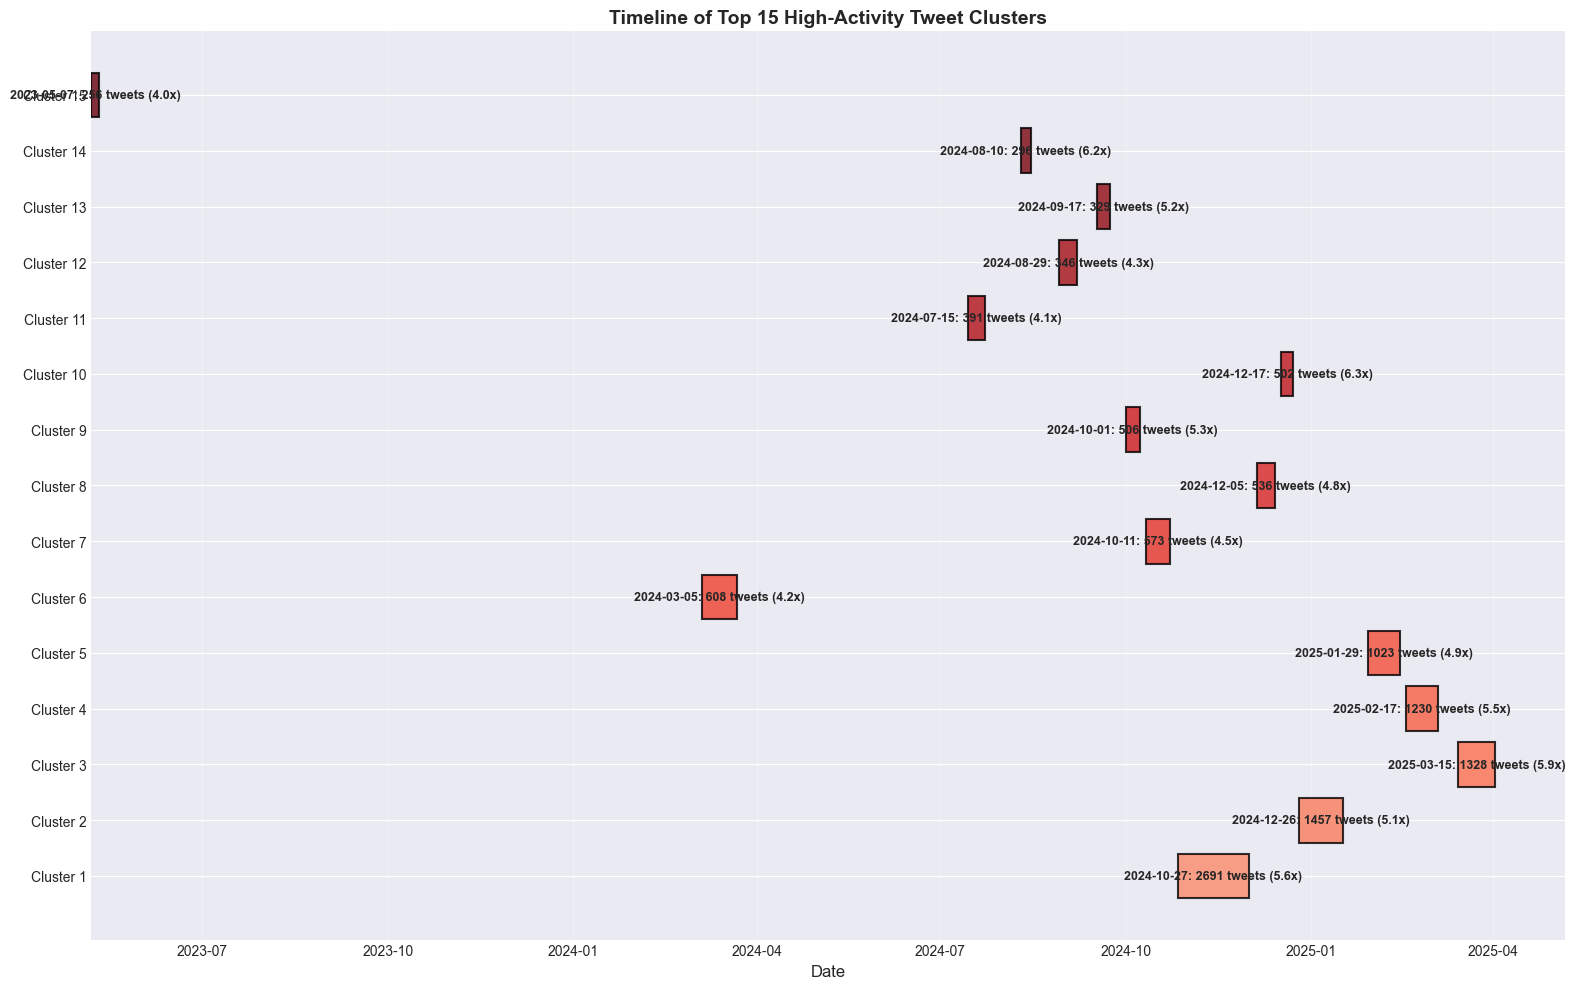


Top 15 clusters summary:
   start_date   end_date  days  total_tweets  avg_tweets
50 2024-10-27 2024-11-30    30          2691   89.700000
53 2024-12-26 2025-01-16    18          1457   80.944444
57 2025-03-15 2025-04-01    14          1328   94.857143
56 2025-02-17 2025-03-04    14          1230   87.857143
55 2025-01-29 2025-02-13    13          1023   78.692308
34 2024-03-05 2024-03-21     9           608   67.555556
49 2024-10-11 2024-10-22     8           573   71.625000
51 2024-12-05 2024-12-13     7           536   76.571429
48 2024-10-01 2024-10-07     6           506   84.333333
52 2024-12-17 2024-12-22     5           502  100.400000
41 2024-07-15 2024-07-22     6           391   65.166667
44 2024-08-29 2024-09-06     5           346   69.200000
46 2024-09-17 2024-09-22     4           329   82.250000
43 2024-08-10 2024-08-14     3           296   98.666667
13 2023-05-07 2023-05-10     4           256   64.000000


In [16]:
# Visualize top 15 clusters on timeline
top_clusters = clusters.head(15).copy()

fig, ax = plt.subplots(figsize=(16, 10))

# Color gradient based on intensity
colors = plt.cm.Reds(np.linspace(0.4, 1, len(top_clusters)))

for idx, (i, cluster) in enumerate(top_clusters.iterrows()):
    start = cluster['start_date']
    end = cluster['end_date']
    duration = (end - start).days + 1
    
    # Plot horizontal bar
    ax.barh(idx, duration, left=start, height=0.8, 
            color=colors[idx], alpha=0.8, edgecolor='black', linewidth=1.5)
    
    # Add label
    intensity = cluster['avg_tweets'] / mean_tweets
    label = f"{start.strftime('%Y-%m-%d')}: {cluster['total_tweets']:.0f} tweets ({intensity:.1f}x)"
    ax.text(start + timedelta(days=duration/2), idx, label, 
            ha='center', va='center', fontsize=9, fontweight='bold')

ax.set_yticks(range(len(top_clusters)))
ax.set_yticklabels([f"Cluster {i+1}" for i in range(len(top_clusters))])
ax.set_xlabel('Date', fontsize=12)
ax.set_title('Timeline of Top 15 High-Activity Tweet Clusters', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("\nTop 15 clusters summary:")
print(top_clusters[['start_date', 'end_date', 'days', 'total_tweets', 'avg_tweets']])

### High-Activity Cluster Timeline Visualization

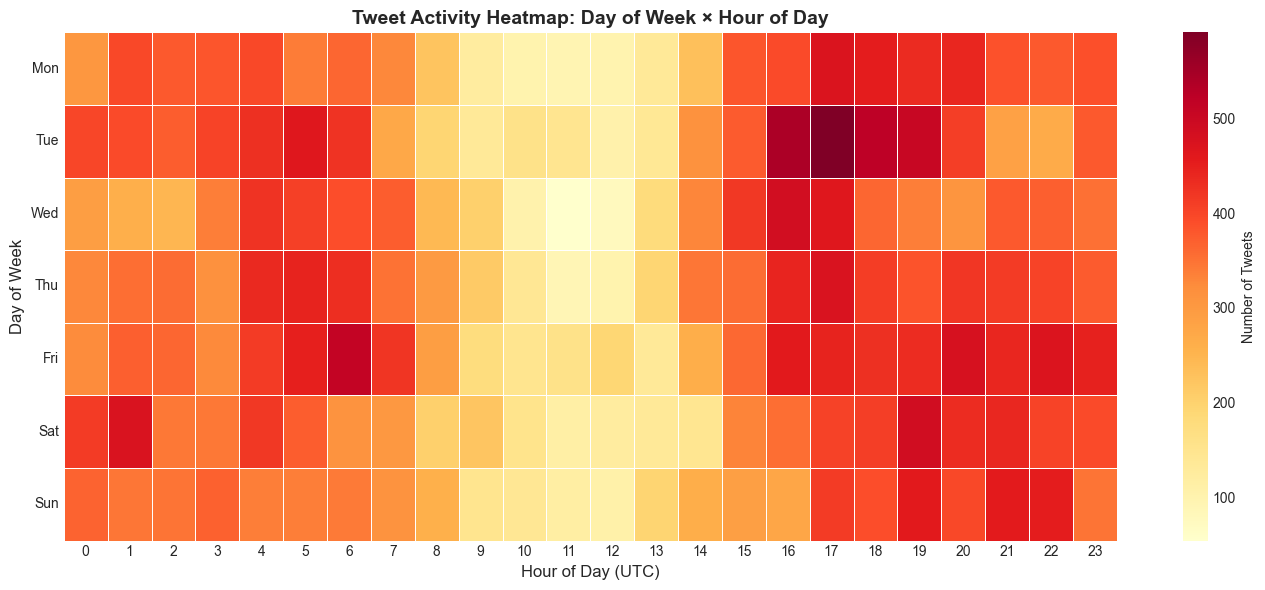


Peak activity slot: Tuesday at 17:00 UTC
Total tweets in this slot: 591


In [15]:
# Create hour-day heatmap
df_tweets['day_of_week_num'] = df_tweets['createdAt'].dt.dayofweek
heatmap_data = df_tweets.groupby(['day_of_week_num', 'hour']).size().unstack(fill_value=0)

# Reorder days
heatmap_data = heatmap_data.reindex(range(7))

# Plot
fig, ax = plt.subplots(figsize=(14, 6))

sns.heatmap(heatmap_data, cmap='YlOrRd', annot=False, fmt='d', 
            cbar_kws={'label': 'Number of Tweets'},
            linewidths=0.5, ax=ax)

ax.set_xlabel('Hour of Day (UTC)', fontsize=12)
ax.set_ylabel('Day of Week', fontsize=12)
ax.set_title('Tweet Activity Heatmap: Day of Week × Hour of Day', fontsize=14, fontweight='bold')
ax.set_yticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=0)

plt.tight_layout()
plt.show()

# Find peak activity slot
peak_idx = heatmap_data.stack().idxmax()
peak_day = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'][peak_idx[0]]
peak_hour = peak_idx[1]
print(f"\nPeak activity slot: {peak_day} at {peak_hour:02d}:00 UTC")
print(f"Total tweets in this slot: {heatmap_data.loc[peak_idx[0], peak_idx[1]]:,}")

### Heatmap: Tweet Activity by Day of Week and Hour

/var/folders/31/8pp98wv16bndwy82vg6vrpv00000gp/T/ipykernel_90770/1582140166.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_tweets['year_month'] = df_tweets['createdAt'].dt.to_period('M')


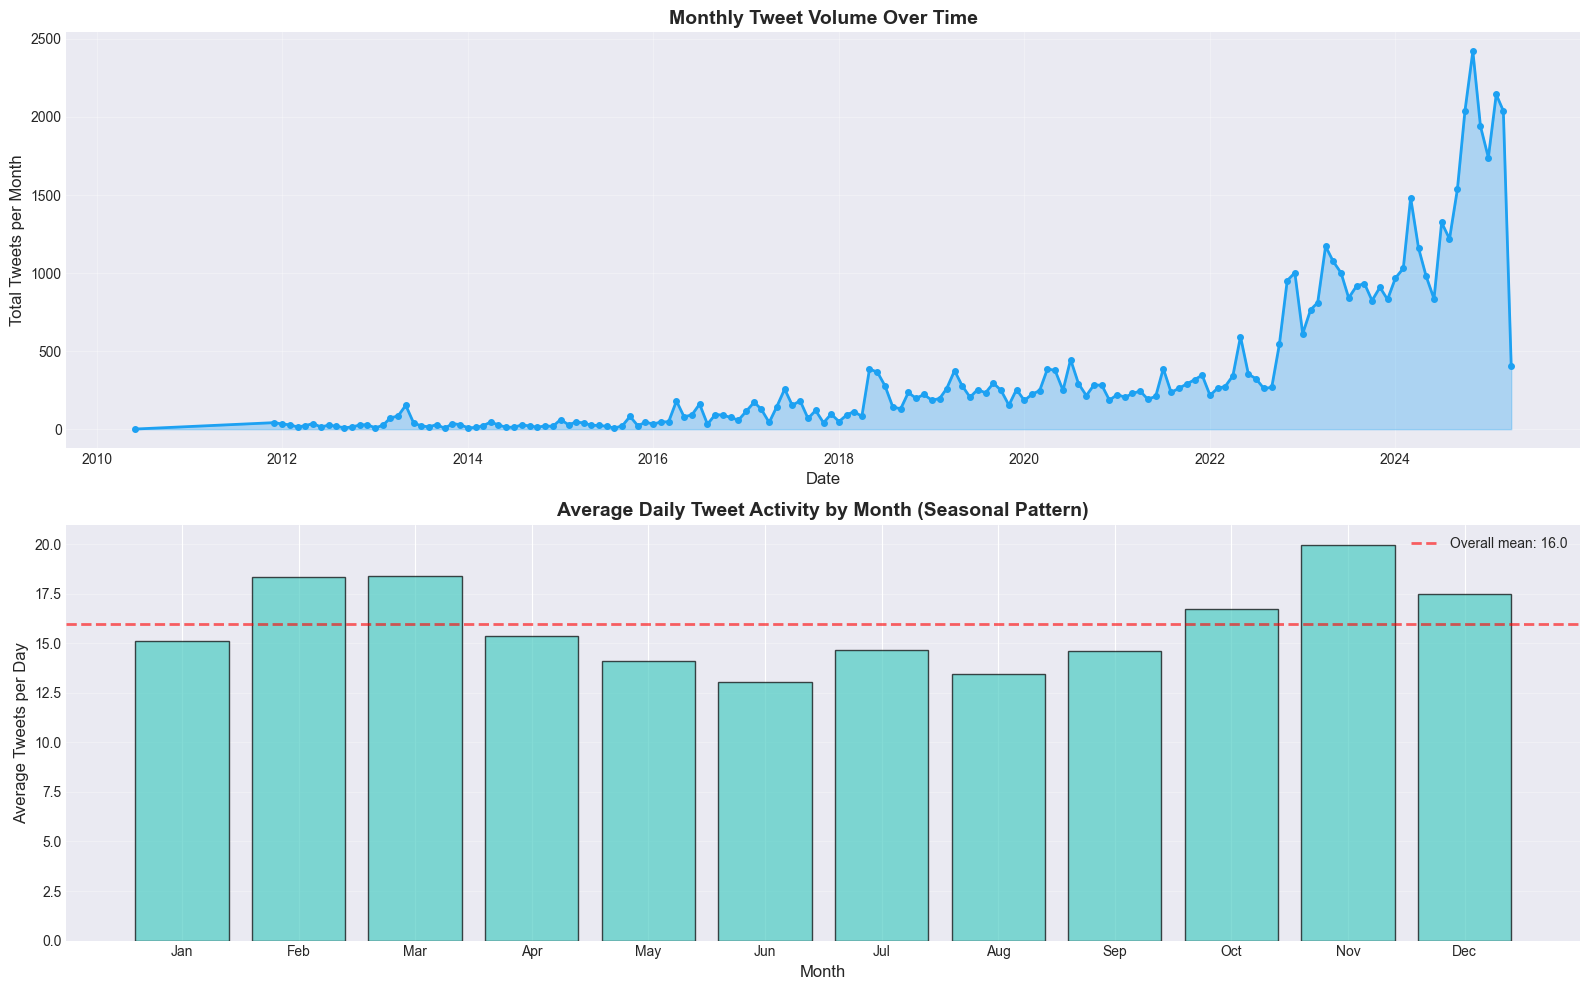


Highest volume month (all-time): November 2024
Tweet count: 2,421

Most active month on average: Nov
Average tweets/day: 20.0


In [14]:
# Monthly aggregation
df_tweets['year_month'] = df_tweets['createdAt'].dt.to_period('M')
monthly_tweets = df_tweets.groupby('year_month').size().reset_index(name='tweet_count')
monthly_tweets['year_month'] = monthly_tweets['year_month'].dt.to_timestamp()

# Calculate month of year statistics
df_tweets['month'] = df_tweets['createdAt'].dt.month
monthly_stats = daily_tweets.copy()
monthly_stats['month'] = monthly_stats['date'].dt.month
monthly_avg = monthly_stats.groupby('month')['tweet_count'].mean()

# Plot monthly time series
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Time series
axes[0].plot(monthly_tweets['year_month'], monthly_tweets['tweet_count'], 
             linewidth=2, color='#1DA1F2', marker='o', markersize=4)
axes[0].fill_between(monthly_tweets['year_month'], monthly_tweets['tweet_count'], 
                      alpha=0.3, color='#1DA1F2')
axes[0].set_xlabel('Date', fontsize=12)
axes[0].set_ylabel('Total Tweets per Month', fontsize=12)
axes[0].set_title('Monthly Tweet Volume Over Time', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Seasonal pattern
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
axes[1].bar(range(1, 13), monthly_avg.values, 
            color='#4ECDC4', alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Month', fontsize=12)
axes[1].set_ylabel('Average Tweets per Day', fontsize=12)
axes[1].set_title('Average Daily Tweet Activity by Month (Seasonal Pattern)', fontsize=14, fontweight='bold')
axes[1].set_xticks(range(1, 13))
axes[1].set_xticklabels(month_names)
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].axhline(y=mean_tweets, color='red', linestyle='--', 
                linewidth=2, alpha=0.6, label=f'Overall mean: {mean_tweets:.1f}')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"\nHighest volume month (all-time): {monthly_tweets.loc[monthly_tweets['tweet_count'].idxmax(), 'year_month'].strftime('%B %Y')}")
print(f"Tweet count: {monthly_tweets['tweet_count'].max():,}")
print(f"\nMost active month on average: {month_names[monthly_avg.idxmax() - 1]}")
print(f"Average tweets/day: {monthly_avg.max():.1f}")

### Monthly Trends and Seasonality


Tweet Activity by Day of Week:
             mean  median   std  max
day_of_week                         
Monday       15.7     8.0  20.2  132
Tuesday      16.4     7.0  23.2  156
Wednesday    14.6     7.0  19.5  132
Thursday     16.2     9.0  20.1  127
Friday       17.3     9.5  20.4  137
Saturday     15.6     8.0  18.9  103
Sunday       15.9     8.0  20.0  158


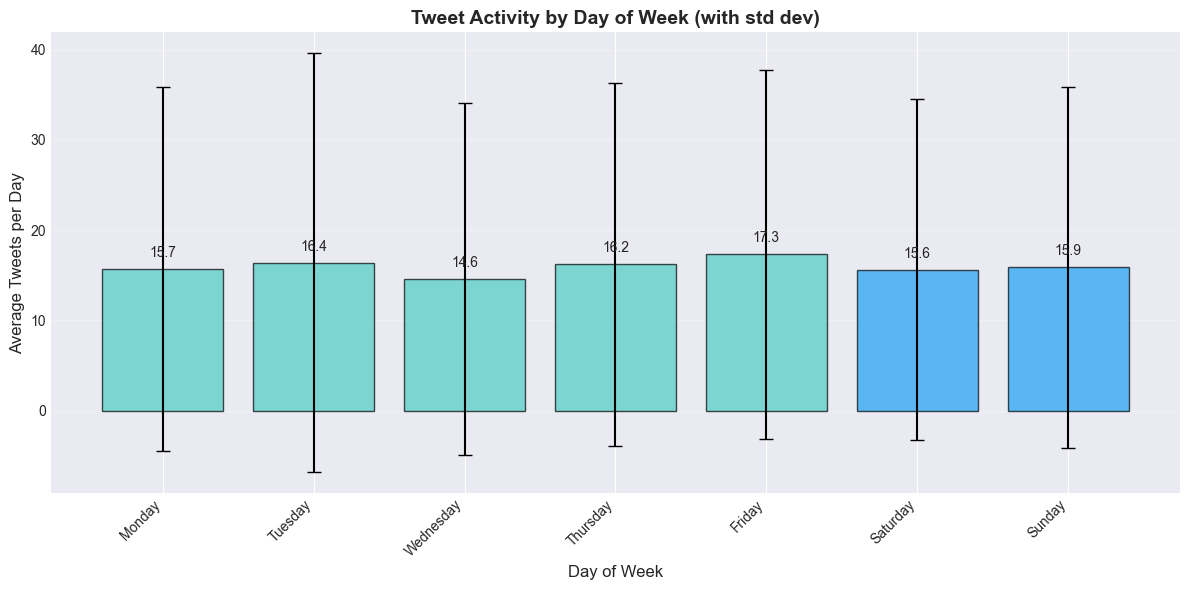

In [13]:
# Add day of week
daily_tweets['day_of_week'] = daily_tweets['date'].dt.day_name()
daily_tweets['day_num'] = daily_tweets['date'].dt.dayofweek

# Average tweets by day of week
dow_stats = daily_tweets.groupby('day_of_week')['tweet_count'].agg(['mean', 'median', 'std', 'max']).round(1)

# Reorder days properly
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_stats = dow_stats.reindex(day_order)

print("\nTweet Activity by Day of Week:")
print(dow_stats)

# Visualize
fig, ax = plt.subplots(figsize=(12, 6))

x_pos = np.arange(len(day_order))
bars = ax.bar(x_pos, dow_stats['mean'], 
              yerr=dow_stats['std'], capsize=5,
              color=['#1DA1F2' if day in ['Saturday', 'Sunday'] else '#4ECDC4' for day in day_order],
              alpha=0.7, edgecolor='black')

ax.set_xlabel('Day of Week', fontsize=12)
ax.set_ylabel('Average Tweets per Day', fontsize=12)
ax.set_title('Tweet Activity by Day of Week (with std dev)', fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(day_order, rotation=45, ha='right')
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars, dow_stats['mean'])):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
            f'{val:.1f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

### Day of Week Patterns

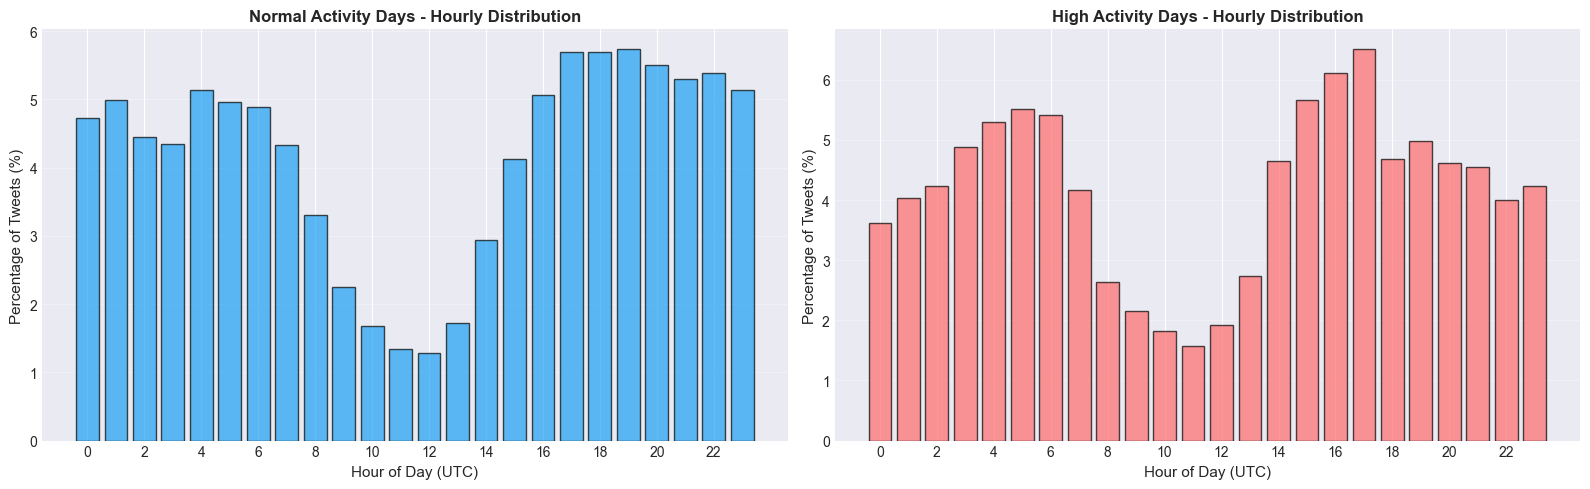


Peak hours during normal activity: {19: 5.736662767634644, 17: 5.693434369119666, 18: 5.693434369119666}
Peak hours during high activity: {17: 6.511126608761808, 16: 6.118049831991377, 15: 5.661573575096685}


In [12]:
# Extract hour of day for all tweets
df_tweets['hour'] = df_tweets['createdAt'].dt.hour

# Separate high-activity vs normal activity tweets
high_activity_dates = set(high_activity_days['date'].dt.date)
df_tweets['is_high_activity'] = df_tweets['createdAt'].dt.date.isin(high_activity_dates)

# Hour distribution
hourly_normal = df_tweets[~df_tweets['is_high_activity']].groupby('hour').size()
hourly_high = df_tweets[df_tweets['is_high_activity']].groupby('hour').size()

# Normalize to percentages
hourly_normal_pct = (hourly_normal / hourly_normal.sum() * 100)
hourly_high_pct = (hourly_high / hourly_high.sum() * 100)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Normal activity pattern
axes[0].bar(hourly_normal_pct.index, hourly_normal_pct.values, 
            color='#1DA1F2', alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Hour of Day (UTC)', fontsize=11)
axes[0].set_ylabel('Percentage of Tweets (%)', fontsize=11)
axes[0].set_title('Normal Activity Days - Hourly Distribution', fontsize=12, fontweight='bold')
axes[0].set_xticks(range(0, 24, 2))
axes[0].grid(True, alpha=0.3, axis='y')

# High activity pattern
axes[1].bar(hourly_high_pct.index, hourly_high_pct.values, 
            color='#FF6B6B', alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Hour of Day (UTC)', fontsize=11)
axes[1].set_ylabel('Percentage of Tweets (%)', fontsize=11)
axes[1].set_title('High Activity Days - Hourly Distribution', fontsize=12, fontweight='bold')
axes[1].set_xticks(range(0, 24, 2))
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\nPeak hours during normal activity: {hourly_normal_pct.nlargest(3).to_dict()}")
print(f"Peak hours during high activity: {hourly_high_pct.nlargest(3).to_dict()}")

### Time-of-Day Patterns During High Activity

Analyze what times of day Musk tweets most during high-activity periods.

In [11]:
# Analyze top 5 highest-volume clusters in detail
top_5_clusters = clusters.head(5).copy()

print("=" * 80)
print("TOP 5 TWEET DENSITY CLUSTERS - DETAILED ANALYSIS")
print("=" * 80)

for idx, cluster in top_5_clusters.iterrows():
    print(f"\n{'='*80}")
    print(f"CLUSTER #{idx + 1}")
    print(f"{'='*80}")
    print(f"Period: {cluster['start_date'].date()} to {cluster['end_date'].date()}")
    print(f"Duration: {cluster['days']} days")
    print(f"Total tweets: {cluster['total_tweets']:,.0f}")
    print(f"Average tweets/day: {cluster['avg_tweets']:.1f}")
    print(f"Peak tweets in a day: {cluster['peak_tweets']:.0f}")
    print(f"Activity intensity: {cluster['avg_tweets'] / mean_tweets:.1f}x normal activity")
    
    # Get tweets from this cluster period
    cluster_tweets = df_tweets[
        (df_tweets['createdAt'].dt.date >= cluster['start_date'].date()) & 
        (df_tweets['createdAt'].dt.date <= cluster['end_date'].date())
    ]
    
    # Calculate engagement metrics
    avg_likes = cluster_tweets['likeCount'].mean()
    avg_retweets = cluster_tweets['retweetCount'].mean()
    avg_replies = cluster_tweets['replyCount'].mean()
    
    print(f"\nEngagement metrics during cluster:")
    print(f"  Average likes: {avg_likes:,.0f}")
    print(f"  Average retweets: {avg_retweets:,.0f}")
    print(f"  Average replies: {avg_replies:,.0f}")
    
    # Tweet type distribution
    retweet_pct = (cluster_tweets['isRetweet'] == True).sum() / len(cluster_tweets) * 100
    reply_pct = (cluster_tweets['isReply'] == True).sum() / len(cluster_tweets) * 100
    quote_pct = (cluster_tweets['isQuote'] == True).sum() / len(cluster_tweets) * 100
    
    print(f"\nTweet type distribution:")
    print(f"  Retweets: {retweet_pct:.1f}%")
    print(f"  Replies: {reply_pct:.1f}%")
    print(f"  Quote tweets: {quote_pct:.1f}%")

TOP 5 TWEET DENSITY CLUSTERS - DETAILED ANALYSIS

CLUSTER #51
Period: 2024-10-27 to 2024-11-30
Duration: 30 days
Total tweets: 2,691
Average tweets/day: 89.7
Peak tweets in a day: 158
Activity intensity: 5.6x normal activity

Engagement metrics during cluster:
  Average likes: 73,502
  Average retweets: 9,853
  Average replies: 3,208

Tweet type distribution:
  Retweets: 0.0%
  Replies: 61.4%
  Quote tweets: 32.6%

CLUSTER #54
Period: 2024-12-26 to 2025-01-16
Duration: 18 days
Total tweets: 1,457
Average tweets/day: 80.9
Peak tweets in a day: 115
Activity intensity: 5.1x normal activity

Engagement metrics during cluster:
  Average likes: 51,867
  Average retweets: 8,013
  Average replies: 3,104

Tweet type distribution:
  Retweets: 0.0%
  Replies: 61.8%
  Quote tweets: 32.8%

CLUSTER #58
Period: 2025-03-15 to 2025-04-01
Duration: 14 days
Total tweets: 1,328
Average tweets/day: 94.9
Peak tweets in a day: 150
Activity intensity: 5.9x normal activity

Engagement metrics during cluster:
 

## Deep Dive: High-Activity Period Analysis

Further investigation of tweet patterns during high-activity clusters.

In [9]:
# Identify clusters of consecutive high-activity days
high_activity_days = high_activity_days.sort_values('date')
high_activity_days['date_diff'] = high_activity_days['date'].diff().dt.days

# Start new cluster if gap > 3 days
high_activity_days['cluster'] = (high_activity_days['date_diff'] > 3).cumsum()

# Analyze clusters
clusters = high_activity_days.groupby('cluster').agg({
    'date': ['min', 'max', 'count'],
    'tweet_count': ['sum', 'mean', 'max']
}).reset_index()

clusters.columns = ['cluster_id', 'start_date', 'end_date', 'days', 
                    'total_tweets', 'avg_tweets', 'peak_tweets']
clusters['duration'] = (clusters['end_date'] - clusters['start_date']).dt.days + 1

# Sort by total tweets
clusters = clusters.sort_values('total_tweets', ascending=False)

print(f"\nIdentified {len(clusters)} high-activity clusters")
print(f"\nTop 10 tweet density clusters by total volume:")
print(clusters.head(10)[['start_date', 'end_date', 'days', 'total_tweets', 'avg_tweets', 'peak_tweets']])


Identified 58 high-activity clusters

Top 10 tweet density clusters by total volume:
   start_date   end_date  days  total_tweets  avg_tweets  peak_tweets
50 2024-10-27 2024-11-30    30          2691   89.700000          158
53 2024-12-26 2025-01-16    18          1457   80.944444          115
57 2025-03-15 2025-04-01    14          1328   94.857143          150
56 2025-02-17 2025-03-04    14          1230   87.857143          137
55 2025-01-29 2025-02-13    13          1023   78.692308          106
34 2024-03-05 2024-03-21     9           608   67.555556           78
49 2024-10-11 2024-10-22     8           573   71.625000          105
51 2024-12-05 2024-12-13     7           536   76.571429          106
48 2024-10-01 2024-10-07     6           506   84.333333          130
52 2024-12-17 2024-12-22     5           502  100.400000          137


### Temporal Clustering Analysis

Group consecutive high-activity days into clusters.

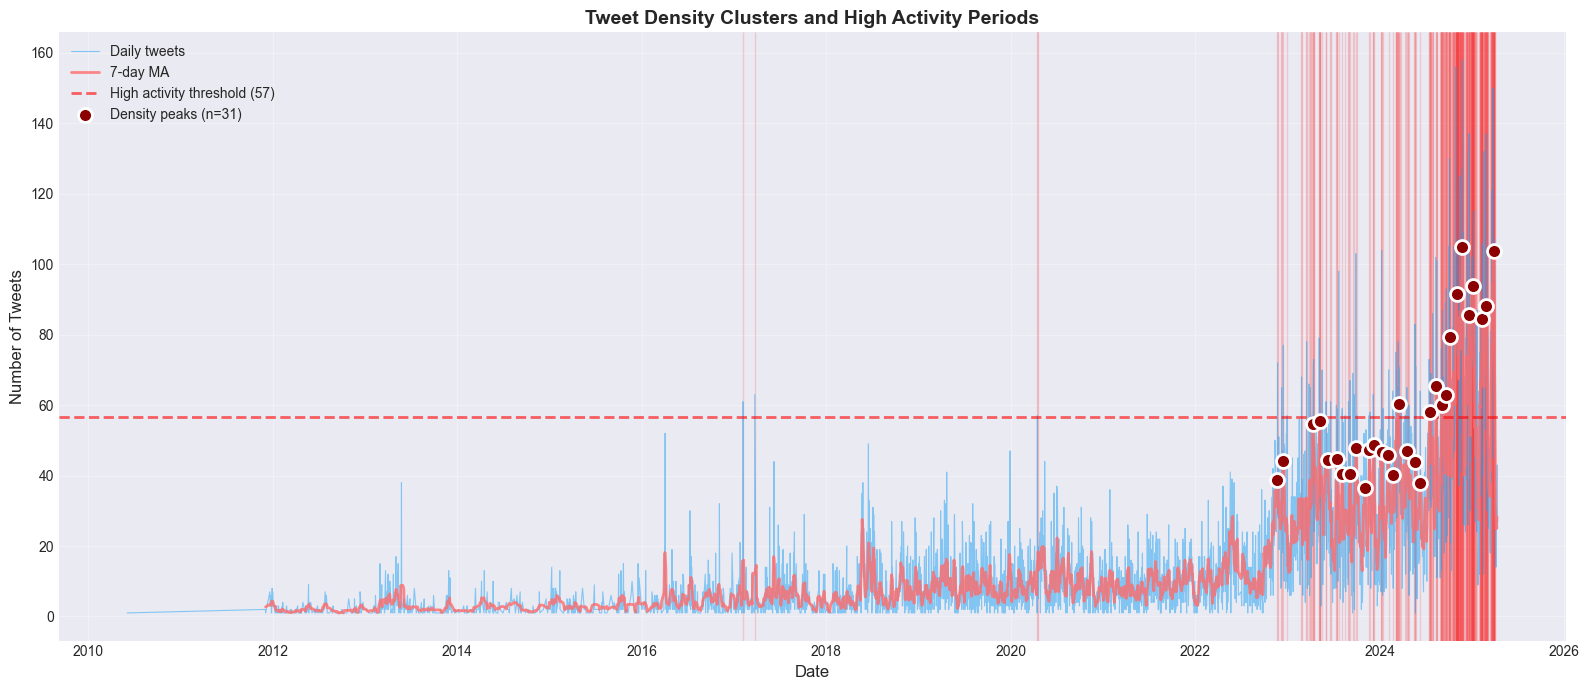

In [8]:
# Visualize tweet density clusters
fig, ax = plt.subplots(figsize=(16, 7))

# Plot daily tweets
ax.plot(daily_tweets['date'], daily_tweets['tweet_count'], 
        linewidth=0.8, alpha=0.5, color='#1DA1F2', label='Daily tweets')

# Plot 7-day MA
ax.plot(daily_tweets['date'], daily_tweets['ma_7'], 
        linewidth=2, alpha=0.8, color='#FF6B6B', label='7-day MA')

# Highlight high activity threshold
ax.axhline(y=threshold_high, color='red', linestyle='--', 
           linewidth=2, alpha=0.6, label=f'High activity threshold ({threshold_high:.0f})')

# Mark identified peaks
ax.scatter(daily_tweets.iloc[peaks]['date'], 
          daily_tweets.iloc[peaks]['ma_7'],
          color='darkred', s=100, zorder=5, 
          marker='o', edgecolor='white', linewidth=2,
          label=f'Density peaks (n={len(peaks)})')

# Shade high activity regions
for _, row in high_activity_days.iterrows():
    ax.axvspan(row['date'] - timedelta(days=0.5), 
               row['date'] + timedelta(days=0.5), 
               alpha=0.15, color='red')

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Number of Tweets', fontsize=12)
ax.set_title('Tweet Density Clusters and High Activity Periods', fontsize=14, fontweight='bold')
ax.legend(loc='upper left', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [7]:
# Method 2: Peak detection for identifying local maxima clusters
# Use 7-day MA to smooth and find peaks
peaks, properties = find_peaks(daily_tweets['ma_7'].fillna(0), 
                                height=mean_tweets + std_tweets, 
                                distance=14,  # At least 14 days between peaks
                                prominence=5)  # Minimum prominence

peak_dates = daily_tweets.iloc[peaks][['date', 'tweet_count', 'ma_7']].copy()
peak_dates = peak_dates.sort_values('tweet_count', ascending=False)

print(f"\nIdentified {len(peaks)} tweet activity peaks")
print(f"\nTop 15 tweet density peaks:")
print(peak_dates.head(15))


Identified 31 tweet activity peaks

Top 15 tweet density peaks:
           date  tweet_count        ma_7
3312 2024-11-24          158  104.857143
3405 2025-02-25          137   88.142857
3338 2024-12-20          137   85.571429
3261 2024-10-04          130   79.285714
3390 2025-02-10          104   84.428571
3354 2025-01-05          102   93.857143
3436 2025-03-28           97  103.714286
3289 2024-11-01           78   91.428571
2868 2023-09-06           67   40.428571
3183 2024-07-18           64   58.000000
2816 2023-07-16           59   44.714286
2837 2023-08-06           59   40.428571
2750 2023-05-09           58   55.428571
3232 2024-09-05           58   60.142857
3094 2024-04-20           56   46.857143


In [6]:
# Method 1: Statistical threshold (mean + 2 standard deviations)
mean_tweets = daily_tweets['tweet_count'].mean()
std_tweets = daily_tweets['tweet_count'].std()
threshold_high = mean_tweets + 2 * std_tweets

high_activity_days = daily_tweets[daily_tweets['tweet_count'] > threshold_high].copy()

print(f"Mean daily tweets: {mean_tweets:.2f}")
print(f"Standard deviation: {std_tweets:.2f}")
print(f"High activity threshold (mean + 2σ): {threshold_high:.2f}")
print(f"\nHigh activity days: {len(high_activity_days)} days ({len(high_activity_days)/len(daily_tweets)*100:.2f}%)")
print(f"\nTop 10 highest tweet days:")
print(high_activity_days.nlargest(10, 'tweet_count')[['date', 'tweet_count']])

Mean daily tweets: 15.96
Standard deviation: 20.36
High activity threshold (mean + 2σ): 56.68

High activity days: 202 days (5.85%)

Top 10 highest tweet days:
           date  tweet_count
3312 2024-11-24          158
3286 2024-10-29          156
3433 2025-03-25          150
3338 2024-12-20          137
3405 2025-02-25          137
3336 2024-12-18          132
3397 2025-02-17          132
3261 2024-10-04          130
3309 2024-11-21          127
3302 2024-11-14          125


### Identify Tweet Density Clusters

Use statistical methods to identify periods of unusually high tweet activity.

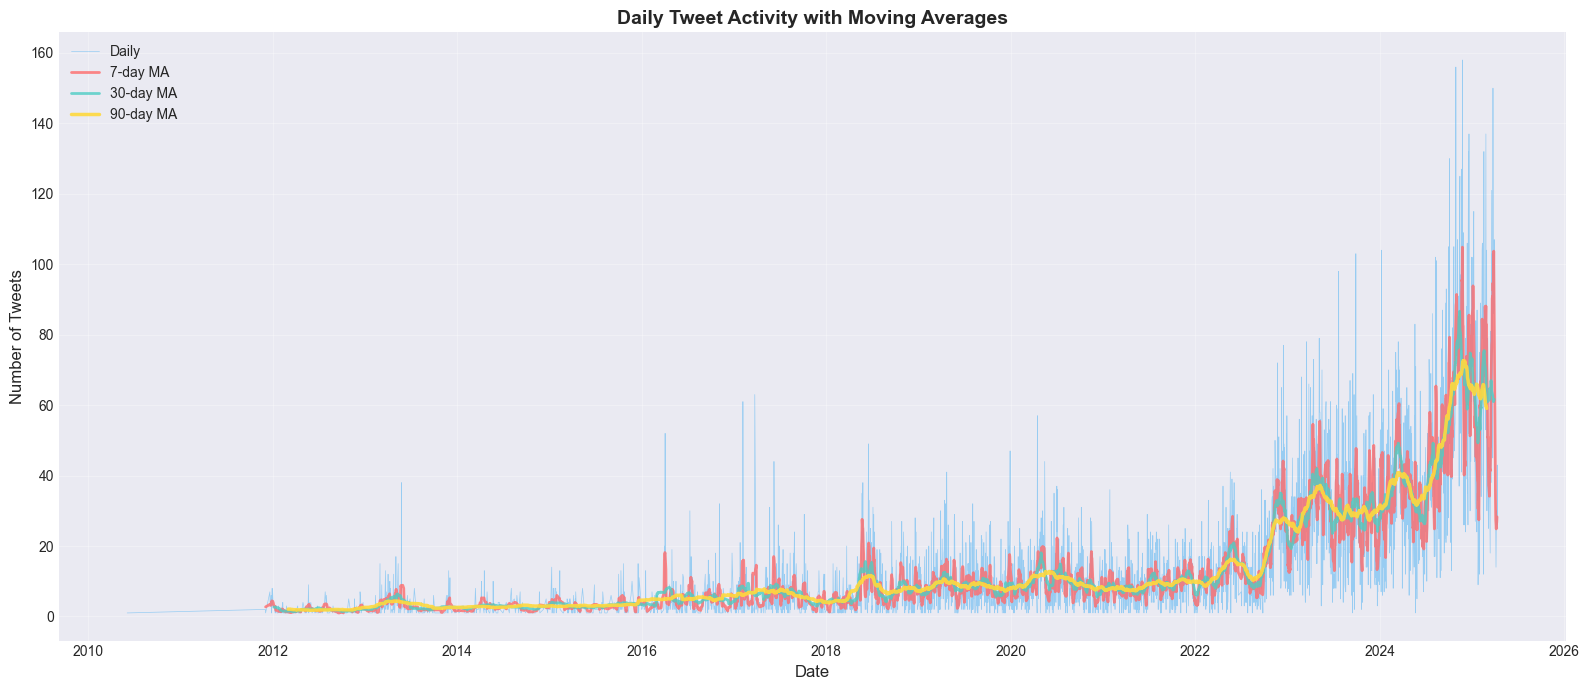

In [5]:
# Calculate rolling averages
daily_tweets['ma_7'] = daily_tweets['tweet_count'].rolling(window=7, center=True).mean()
daily_tweets['ma_30'] = daily_tweets['tweet_count'].rolling(window=30, center=True).mean()
daily_tweets['ma_90'] = daily_tweets['tweet_count'].rolling(window=90, center=True).mean()

# Plot with moving averages
fig, ax = plt.subplots(figsize=(16, 7))

ax.plot(daily_tweets['date'], daily_tweets['tweet_count'], 
        linewidth=0.5, alpha=0.4, color='#1DA1F2', label='Daily')
ax.plot(daily_tweets['date'], daily_tweets['ma_7'], 
        linewidth=2, alpha=0.8, color='#FF6B6B', label='7-day MA')
ax.plot(daily_tweets['date'], daily_tweets['ma_30'], 
        linewidth=2, alpha=0.8, color='#4ECDC4', label='30-day MA')
ax.plot(daily_tweets['date'], daily_tweets['ma_90'], 
        linewidth=2.5, alpha=0.9, color='#FFD93D', label='90-day MA')

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Number of Tweets', fontsize=12)
ax.set_title('Daily Tweet Activity with Moving Averages', fontsize=14, fontweight='bold')
ax.legend(loc='upper left', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Calculate Rolling Averages and Identify High-Activity Periods

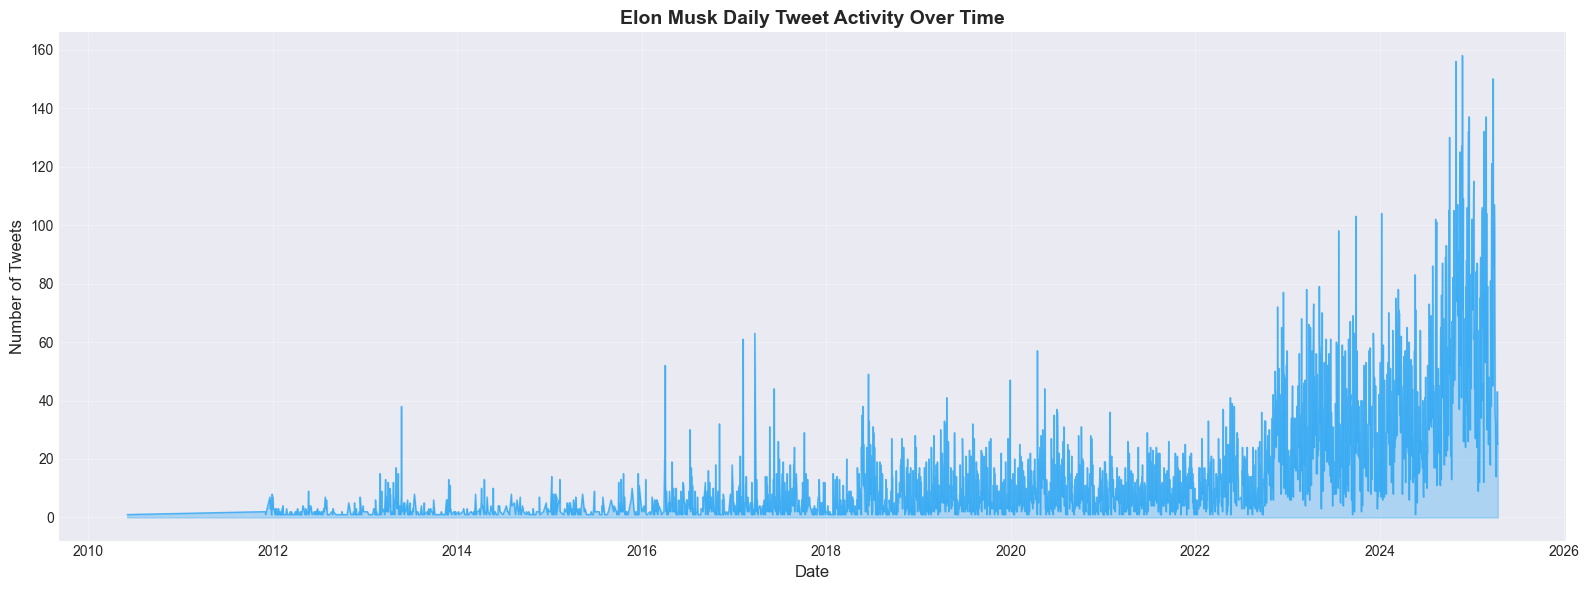


Peak day: 2024-11-24
Peak tweet count: 158 tweets


In [4]:
# Plot daily tweet frequency over time
fig, ax = plt.subplots(figsize=(16, 6))

ax.plot(daily_tweets['date'], daily_tweets['tweet_count'], 
        linewidth=1, alpha=0.7, color='#1DA1F2')
ax.fill_between(daily_tweets['date'], daily_tweets['tweet_count'], 
                 alpha=0.3, color='#1DA1F2')

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Number of Tweets', fontsize=12)
ax.set_title('Elon Musk Daily Tweet Activity Over Time', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nPeak day: {daily_tweets.loc[daily_tweets['tweet_count'].idxmax(), 'date'].date()}")
print(f"Peak tweet count: {daily_tweets['tweet_count'].max()} tweets")

In [3]:
# Aggregate tweets by day
df_tweets['date'] = df_tweets['createdAt'].dt.date
daily_tweets = df_tweets.groupby('date').size().reset_index(name='tweet_count')
daily_tweets['date'] = pd.to_datetime(daily_tweets['date'])

# Sort by date
daily_tweets = daily_tweets.sort_values('date')

print(f"Total days with tweets: {len(daily_tweets):,}")
print(f"\nDaily tweet statistics:")
print(daily_tweets['tweet_count'].describe())

Total days with tweets: 3,453

Daily tweet statistics:
count    3453.000000
mean       15.956849
std        20.364072
min         1.000000
25%         3.000000
50%         8.000000
75%        20.000000
max       158.000000
Name: tweet_count, dtype: float64
